# US cencus income : Ensembles, Bagging and Shap Values


- toc: true
- badges: true
- comments: true
- categories: [jupyter]
- image: images/shap_values.png


# Problem Framework

In [375]:
!ls

Youness ZAIM - Dataiku Assessemnt.ipynb census_income_metadata.txt
census_income_additional_info.pdf       census_income_metadata_column.csv
census_income_learn.csv                 census_income_test.csv


In [187]:
!pwd

/Users/rmbp/Desktop/Dataiku Data Scientist Technical Assessment


In [188]:
# The data can be found in this folder : https://github.com/younesszaim/myportfolio/upload/master/_notebooks/Datasets)
PATH = '/Users/rmbp/Desktop/Dataiku Data Scientist Technical Assessment'

Our task is to determine the income level for the person represented by the record. Incomes have been binned at the $50K level to present a **binary classification problem**.

The dataset used in this analysis was extracted from the census bureau database found at. The data was split into train/test in approximately 2/3, 1/3 proportions.

The following mappings of the data is as follow :

In [189]:
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
import numpy as np

In [190]:
df_labels = pd.read_csv(f'{PATH}/census_income_metadata_column.csv', sep=';')
df_labels.head(5)


,column_name,dtype
0,age,continuous
1,class_of_worker,nominal
2,detailed_industry_recode,nominal
3,detailed_occupation_recode,nominal
4,education,nominal


In any sort of data science work, it's important to look at our data directly to make sure we understand the format, how it's stored, what types of values it holds, etc. Even if we've read a description of the data, the actual data may not be what we expect. We'll start by reading the training set into a Pandas DataFrame :

In [191]:
# Loading the train data 
df = pd.read_csv(f'{PATH}/census_income_learn.csv', names = df_labels['column_name'])
df.shape

(199523, 42)

Let's have a look at the columns, their types defined by Pandas and compared it to their actual mapping types :

In [192]:
# Chekcing the mapping of the data 
d1 = df.dtypes.apply(lambda x: x.name).to_dict()
d2 = {c: d for c,d in zip(df_labels['column_name'],df_labels['dtype'])}
mapping = [d1, d2]
d = {}
for k in d1.keys():
    d[k] = tuple(d[k] for d in mapping)
d

{'age': ('int64', 'continuous'),
 'class_of_worker': ('object', 'nominal'),
 'detailed_industry_recode': ('int64', 'nominal'),
 'detailed_occupation_recode': ('int64', 'nominal'),
 'education': ('object', 'nominal'),
 'wage_per_hour': ('int64', 'continuous'),
 'enroll_in_edu_inst_last_wk': ('object', 'nominal'),
 'marital_stat': ('object', 'nominal'),
 'major_industry_code': ('object', 'nominal'),
 'major_occupation_code': ('object', 'nominal'),
 'race': ('object', 'nominal'),
 'hispanic_origin': ('object', 'nominal'),
 'sex': ('object', 'nominal'),
 'member_of_a_labor_union': ('object', 'nominal'),
 'reason_for_unemployment': ('object', 'nominal'),
 'full_or_part_time_employment_stat': ('object', 'nominal'),
 'capital_gains': ('int64', 'continuous'),
 'capital_losses': ('int64', 'continuous'),
 'dividends_from_stocks': ('int64', 'continuous'),
 'tax_filer_stat': ('object', 'nominal'),
 'region_of_previous_residence': ('object', 'nominal'),
 'state_of_previous_residence': ('object', 'n

We can see that **detailed_industry_recode**, **detailed_occupation_recode**, **own_business_or_self_employed**,
**veterans_benefits** and **year** is set by default as a continuos category. 

Let's redifined their types :

In [193]:
# Correcting data types
d1['detailed_industry_recode']='object'
d1['detailed_occupation_recode']='object'
d1['own_business_or_self_employed']='object'
d1['veterans_benefits']='object'
d1['year']='object'

Let's reload the data with its correspind feature's mapping :

In [194]:
# reload data with coorexted types
df = pd.read_csv(f'{PATH}/census_income_learn.csv', names =df_labels['column_name'],
                 dtype= d1)

The **info()** method is useful to get a quick description of the data, in particular the
total number of rows, each attribute’s type, and the number of nonnull values :

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class_of_worker                             199523 non-null  object 
 2   detailed_industry_recode                    199523 non-null  object 
 3   detailed_occupation_recode                  199523 non-null  object 
 4   education                                   199523 non-null  object 
 5   wage_per_hour                               199523 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  199523 non-null  object 
 7   marital_stat                                199523 non-null  object 
 8   major_industry_code                         199523 non-null  object 
 9   major_occupation_code                       199523 non-null  object 
 

In [196]:
# dispplay first rows 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(df.head(3))

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,ignore,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


In [197]:
# drop 'ignore' column
df.drop('ignore', axis=1,inplace=True)

In [198]:
# list columns
df.columns

Index(['age', 'class_of_worker', 'detailed_industry_recode',
       'detailed_occupation_recode', 'education', 'wage_per_hour',
       'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code',
       'major_occupation_code', 'race', 'hispanic_origin', 'sex',
       'member_of_a_labor_union', 'reason_for_unemployment',
       'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'tax_filer_stat',
       'region_of_previous_residence', 'state_of_previous_residence',
       'detailed_household_and_family_stat',
       'detailed_household_summary_in_household',
       'migration_code-change_in_msa', 'migration_code-change_in_reg',
       'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer',
       'family_members_under_18', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
       'own_business

We load the test set with the same training data types :

In [199]:
# loading the test set 
test = pd.read_csv(f'{PATH}/census_income_test.csv', names =df_labels['column_name'], dtype= d1 )

In [200]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99762 entries, 0 to 99761
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   age                                         99762 non-null  int64  
 1   class_of_worker                             99762 non-null  object 
 2   detailed_industry_recode                    99762 non-null  object 
 3   detailed_occupation_recode                  99762 non-null  object 
 4   education                                   99762 non-null  object 
 5   wage_per_hour                               99762 non-null  int64  
 6   enroll_in_edu_inst_last_wk                  99762 non-null  object 
 7   marital_stat                                99762 non-null  object 
 8   major_industry_code                         99762 non-null  object 
 9   major_occupation_code                       99762 non-null  object 
 10  race      

We verify if we got the same columns both on the train and the test set :

In [201]:
# checking columns on test set which not in train
set(test.columns).difference(set(df.columns))

{'ignore'}

In [202]:
# dropping 'ignore' columns
test.drop('ignore', inplace=True, axis=1)

In [203]:
test.columns

Index(['age', 'class_of_worker', 'detailed_industry_recode',
       'detailed_occupation_recode', 'education', 'wage_per_hour',
       'enroll_in_edu_inst_last_wk', 'marital_stat', 'major_industry_code',
       'major_occupation_code', 'race', 'hispanic_origin', 'sex',
       'member_of_a_labor_union', 'reason_for_unemployment',
       'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses',
       'dividends_from_stocks', 'tax_filer_stat',
       'region_of_previous_residence', 'state_of_previous_residence',
       'detailed_household_and_family_stat',
       'detailed_household_summary_in_household',
       'migration_code-change_in_msa', 'migration_code-change_in_reg',
       'migration_code-move_within_reg', 'live_in_this_house_1_year_ago',
       'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer',
       'family_members_under_18', 'country_of_birth_father',
       'country_of_birth_mother', 'country_of_birth_self', 'citizenship',
       'own_business

In [204]:
# display first rows of the test set
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(test.head(3))

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,38,Private,6,36,1st 2nd 3rd or 4th grade,0,Not in universe,Married-civilian spouse present,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,White,Mexican (Mexicano),Female,Not in universe,Not in universe,Full-time schedules,0,0,0,Joint one under 65 & one 65+,Not in universe,Not in universe,Spouse of householder,Spouse of householder,?,?,?,Not in universe under 1 year old,?,4,Not in universe,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,Not in universe,2,12,95,- 50000.
1,44,Self-employed-not incorporated,37,12,Associates degree-occup /vocational,0,Not in universe,Married-civilian spouse present,Business and repair services,Professional specialty,White,All other,Female,Not in universe,Not in universe,PT for econ reasons usually PT,0,0,2500,Joint both under 65,Not in universe,Not in universe,Spouse of householder,Spouse of householder,?,?,?,Not in universe under 1 year old,?,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,26,95,- 50000.
2,2,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,Mexican-American,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.


In [205]:
df.shape, test.shape

((199523, 41), (99762, 41))

# Looking at the data

The most important data column is the **dependent variable**—that is, the one we want to predict which is **income_level** :

In [206]:
dep_var = 'income_level'

Let's see its distribution :

 - 50000.    0.937942
 50000+.     0.062058
Name: income_level, dtype: float64


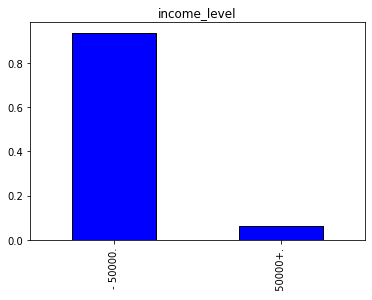

In [207]:
print(df[dep_var].value_counts(normalize = True))
df[dep_var].value_counts(normalize = True).plot(kind='bar',
                                 edgecolor='black',
                                 color='blue',
                                 title='income_level')

We have an **imbalanced dataset** where the income level of -50k is representing more than 93% of the total records.

Next, we automatically handle which columns are **continuous** and which are **categorical** :



In [208]:
# get categorical and numerical variables
def cont_cat_split(df, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
        if label in [dep_var]: continue
        if (pd.api.types.is_integer_dtype(df[label].dtype) or
            pd.api.types.is_float_dtype(df[label].dtype)):
            cont_names.append(label)
        else: cat_names.append(label)
    return cont_names, cat_names

cont, cat = cont_cat_split(df, dep_var= dep_var)
cont , cat

(['age',
  'wage_per_hour',
  'capital_gains',
  'capital_losses',
  'dividends_from_stocks',
  'num_persons_worked_for_employer',
  'weeks_worked_in_year'],
 ['class_of_worker',
  'detailed_industry_recode',
  'detailed_occupation_recode',
  'education',
  'enroll_in_edu_inst_last_wk',
  'marital_stat',
  'major_industry_code',
  'major_occupation_code',
  'race',
  'hispanic_origin',
  'sex',
  'member_of_a_labor_union',
  'reason_for_unemployment',
  'full_or_part_time_employment_stat',
  'tax_filer_stat',
  'region_of_previous_residence',
  'state_of_previous_residence',
  'detailed_household_and_family_stat',
  'detailed_household_summary_in_household',
  'migration_code-change_in_msa',
  'migration_code-change_in_reg',
  'migration_code-move_within_reg',
  'live_in_this_house_1_year_ago',
  'migration_prev_res_in_sunbelt',
  'family_members_under_18',
  'country_of_birth_father',
  'country_of_birth_mother',
  'country_of_birth_self',
  'citizenship',
  'own_business_or_self_empl

Let's start by checking the modalties of our categorical variables :

In [209]:
# Check modalities of categorical varaiblies
for c in cat :
       print(pd.DataFrame({c : df[c].value_counts()/len(df)}))
         

                                 class_of_worker
 Not in universe                        0.502423
 Private                                0.361001
 Self-employed-not incorporated         0.042326
 Local government                       0.039013
 State government                       0.021186
 Self-employed-incorporated             0.016364
 Federal government                     0.014660
 Never worked                           0.002200
 Without pay                            0.000827
     detailed_industry_recode
 0                   0.504624
 33                  0.085554
 43                  0.041514
 4                   0.029992
 42                  0.023471
 45                  0.022464
 29                  0.021095
 37                  0.020158
 41                  0.019867
 32                  0.018023
 35                  0.016940
 39                  0.014720
 34                  0.013858
 44                  0.012775
 2                   0.011006
 11                  0.008841


              sex
 Female  0.521163
 Male    0.478837
                  member_of_a_labor_union
 Not in universe                 0.904452
 No                              0.080362
 Yes                             0.015186
                        reason_for_unemployment
 Not in universe                       0.969577
 Other job loser                       0.010214
 Re-entrant                            0.010119
 Job loser - on layoff                 0.004892
 Job leaver                            0.002997
 New entrant                           0.002200
                                     full_or_part_time_employment_stat
 Children or Armed Forces                                     0.620324
 Full-time schedules                                          0.204167
 Not in labor force                                           0.134360
 PT for non-econ reasons usually FT                           0.016650
 Unemployed full-time                                         0.011583
 PT for econ rea

                               migration_code-move_within_reg
 ?                                                   0.499672
 Nonmover                                            0.413677
 Same county                                         0.049177
 Different county same state                         0.014018
 Not in universe                                     0.007598
 Different state in South                            0.004877
 Different state in West                             0.003403
 Different state in Midwest                          0.002762
 Abroad                                              0.002656
 Different state in Northeast                        0.002160
                                   live_in_this_house_1_year_ago
 Not in universe under 1 year old                       0.507270
 Yes                                                    0.413677
 No                                                     0.079054
                  migration_prev_res_in_sunbelt
 ?        

         year
 94  0.500328
 95  0.499672


Some categorical features are **purely nominal**-having multiple modalities (with modality **?** for nan values) and 
others are **ordinal columns** like **education** and **year**:

In [210]:
# Ediucation modalities
df['education'].unique(), df['education'].nunique()

(array([' High school graduate', ' Some college but no degree',
        ' 10th grade', ' Children', ' Bachelors degree(BA AB BS)',
        ' Masters degree(MA MS MEng MEd MSW MBA)', ' Less than 1st grade',
        ' Associates degree-academic program', ' 7th and 8th grade',
        ' 12th grade no diploma', ' Associates degree-occup /vocational',
        ' Prof school degree (MD DDS DVM LLB JD)', ' 5th or 6th grade',
        ' 11th grade', ' Doctorate degree(PhD EdD)', ' 9th grade',
        ' 1st 2nd 3rd or 4th grade'], dtype=object),
 17)

In [211]:
# Year modalities
df['year'].unique(), df['year'].nunique()

(array([' 95', ' 94'], dtype=object), 2)

We can tell Pandas about a suitable ordering of these levels like so:

In [212]:
# Setting the order of education variable
education = ' Children',' Less than 1st grade',' 1st 2nd 3rd or 4th grade',' 5th or 6th grade',\
' 7th and 8th grade',' 9th grade',' 10th grade',' 11th grade', ' 12th grade no diploma',\
' High school graduate', ' Associates degree-academic program',' Associates degree-occup /vocational',\
' Prof school degree (MD DDS DVM LLB JD)',' Some college but no degree',' Bachelors degree(BA AB BS)',\
' Masters degree(MA MS MEng MEd MSW MBA)',' Doctorate degree(PhD EdD)'
len(education)

17

In [213]:
# Setting the order of year variaable
year = '94', '95'

In [214]:
# apply the defined ordering fot our data :
df['education'] = df['education'].astype('category')
df['education'].cat.set_categories(education, ordered=True, inplace=True)

df['year'] = df['year'].astype('category')
df['year'].cat.set_categories(year, ordered=True, inplace=True)

#Same for test set :
test['education'] = test['education'].astype('category')
test['education'].cat.set_categories(education, ordered=True, inplace=True)

test['year'] = test['year'].astype('category')
test['year'].cat.set_categories(year, ordered=True, inplace=True)

/Users/rmbp/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


Lets check our continous features: 
The **describe()** method shows a summary of the numerical attributes

In [215]:
df[cont].describe()

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
count,199523.000000,199523.000000,199523.00000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494199,55.426908,434.71899,37.313788,197.529533,1.956180,23.174897
std,22.310895,274.896454,4697.53128,271.896428,1984.163658,2.365126,24.411488
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.00000,0.000000,0.000000,1.000000,8.000000
75%,50.000000,0.000000,0.00000,0.000000,0.000000,4.000000,52.000000
max,90.000000,9999.000000,99999.00000,4608.000000,99999.000000,6.000000,52.000000


The **count**, **mean**, **min**, and **max** rows are self-explanatory.The **std** row shows the standard deviation, which measures how dispersed the values are. The 25%, 50%, and 75% rows show the corresponding percentiles.

We plot a histogram for each numerical attribute :

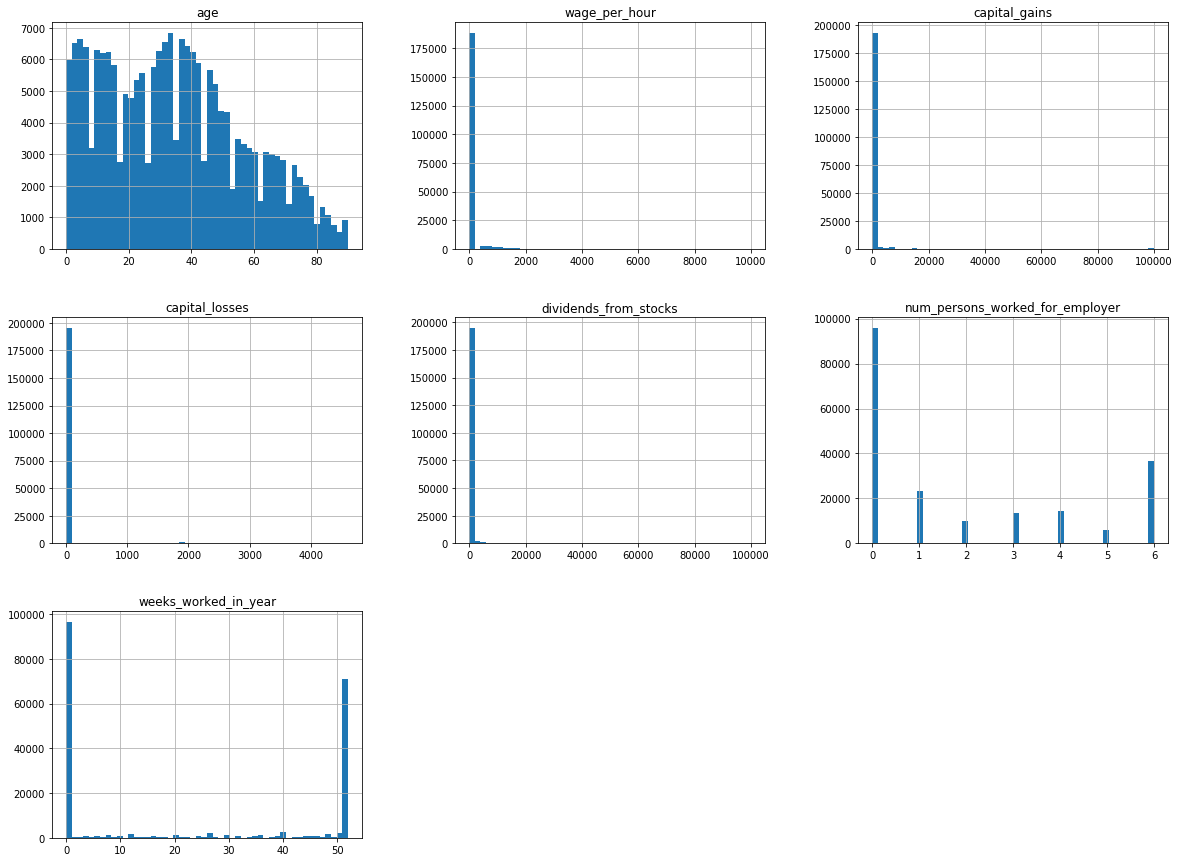

In [216]:
%matplotlib inline 
import matplotlib.pyplot as plt
df[cont].hist(bins=50, figsize=(20,15))
plt.show()

- We can see that these attributes have very **different scales**.

- Some numerical varaibles are countinous like **age** and others are discrete and finite like **weeks_worked_in_year** or infinete **num_persons_worked_for_employer**.

- Some features as **wage_per_hour**,**capital_gains**,**capital_losses**,**dividends_from_stocks** are tail-heavy: they extend much farther to the median right with high coefficient of variation :


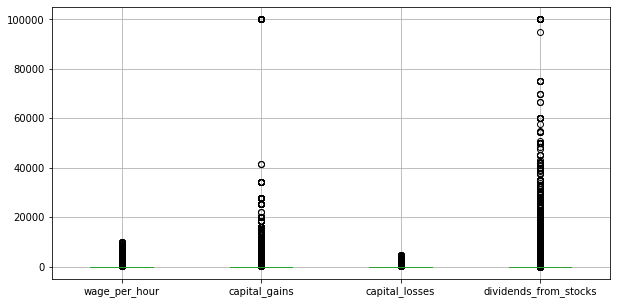

In [217]:
df[cont].boxplot(column=['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks'],
                 figsize=(10,5))

We can see the presence of **extreme values** for those features.

Using the **skewness value**, which explains the extent to which the data is normally distributed, in order to confirm that. 
Ideally, the skewness value should be between -1 and +1, and any major deviation from this range indicates the presence of extreme values.

We can calculate the skwenss value :

In [218]:
# skewness value
df[['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks']].skew()

wage_per_hour             8.935097
capital_gains            18.990822
capital_losses            7.632565
dividends_from_stocks    27.786502
dtype: float64

Using the **IQR score**, let's see the number of obseravtions that are not in the `(Q1 - 1.5 IQR) and (Q3 + 1.5 IQR)` range :

In [219]:
# IQR score
Q1 = df[['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks']].quantile(0.25)
Q3 = df[['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks']].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

wage_per_hour            0.0
capital_gains            0.0
capital_losses           0.0
dividends_from_stocks    0.0
dtype: float64


In [220]:
# number of observation out of the definied range
out = df[['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks']]
df_out = out[((out < (Q1 - 1.5 * IQR)) |(out > (Q3 + 1.5 * IQR))).any(axis=1)]

out.shape, df_out.shape, df_out.shape[0]/out.shape[0]

((199523, 4), (38859, 4), 0.1947595014108649)

From 199.523 observation of the selcted features, 38.859 records (19%) represent extrem values.

For **weeks_worked_in_year** :

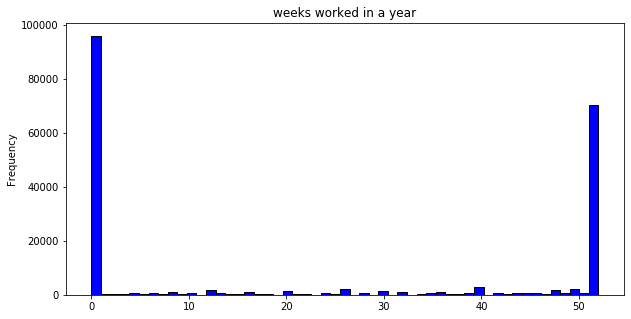

In [221]:
df['weeks_worked_in_year'].plot( kind='hist',
                                 bins=53,
                                 edgecolor='black',
                                 color='blue',
                                 title='weeks worked in a year',
                                 figsize=(10,5))

For **num_persons_worked_for_employer** :

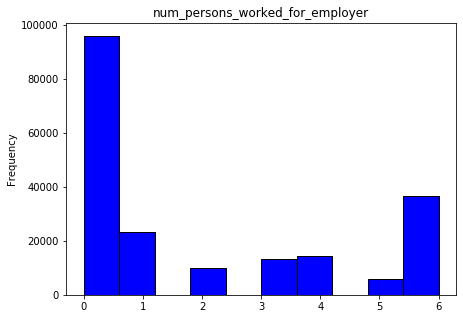

In [222]:
df['num_persons_worked_for_employer'].plot( kind='hist',
                                 
                                 edgecolor='black',
                                 color='blue',
                                 title='num_persons_worked_for_employer',
                                 figsize=(7,5))


We notice an increase in the 7th bins **num_persons_worked_for_employer=6**. Check if this variable is capped ?

# Exploratory data analysis

- Starting with **numerical variables** :

In [223]:
import seaborn as sns

(array([0]), <a list of 1 Text xticklabel objects>)

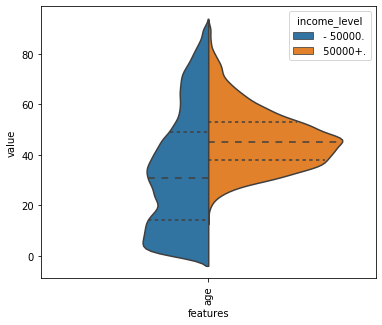

In [224]:
data_dia = df[dep_var]
data = df[['age']]
data = pd.concat([data_dia,data],axis=1)
data = pd.melt(data,id_vars="income_level",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(6,5))
sns.violinplot(x="features", y="value", hue="income_level", data=data,split=True, inner="quartile")
plt.xticks(rotation=90)

For the **age** feature, we can see that the medians of the income levels +/- 50k look separated. 
The income level of +50k with a median of 50 years old has a lower interquntile range (IQR) with value spread of 10 years. Whereas The income level of -50k has a median of 30 years old has and interquantile range (IQR) of 40 years.
So, **age** can be good for classification.

Let's look at the **weeks_worked_in_year** feature :

In [225]:
# get the number of income class in each week
weeks_worked_in_year = df.groupby(["weeks_worked_in_year", "income_level"])\
                        .size()\
                        .groupby(level=0).apply(lambda x: 100*x/x.sum()).unstack()

# print the percentage class for the first and last weeks 
weeks_worked_in_year.iloc[[0,1,2, -3,-2,-1]]

income_level,- 50000.,50000+.
weeks_worked_in_year,,
0,99.379057,0.620943
1,98.275862,1.724138
2,98.908297,1.091703
50,89.279514,10.720486
51,89.010989,10.989011
52,85.199249,14.800751


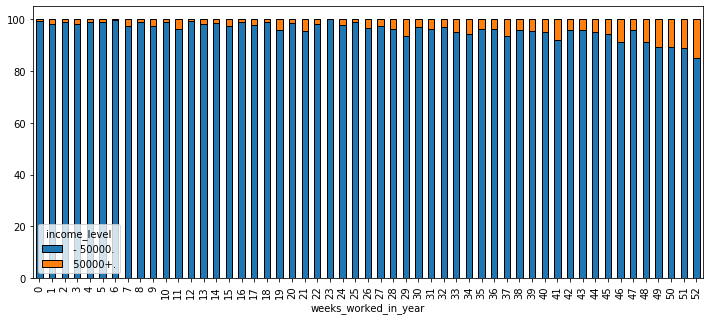

In [226]:
weeks_worked_in_year.plot(kind='bar', 
                          stacked=True,
                          edgecolor='black', 
                          figsize=(12,5))

We can see that the propotion of people making more than 50k a year is increasing with the number of working weeks in a given year where it can reach more than 14% for those working 52 weeks . 
However, the -50k level of income is representing the higher propotion regardless of the number of working weeks.
We notice that among those how don't work at all, 0.6% still make more than 50k a year.

Let's look at **num_persons_worked_for_employer** :

In [227]:
num_persons_worked_for_employer = df.groupby(["num_persons_worked_for_employer", "income_level"])\
                        .size()\
                        .groupby(level=0).apply(lambda x: 100*x/x.sum()).unstack()

num_persons_worked_for_employer

income_level,- 50000.,50000+.
num_persons_worked_for_employer,,
0,99.379057,0.620943
1,90.942923,9.057077
2,91.687333,8.312667
3,90.763501,9.236499
4,89.776758,10.223242
5,88.980944,11.019056
6,84.990825,15.009175


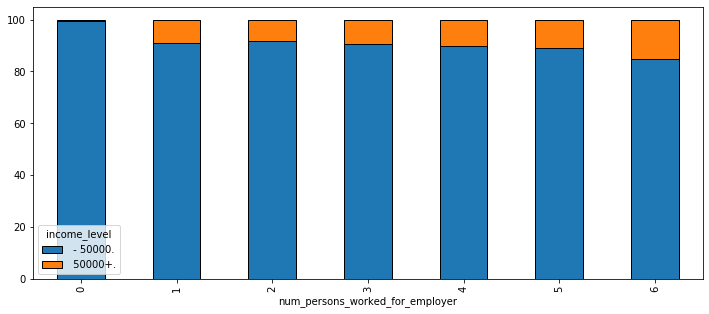

In [228]:
num_persons_worked_for_employer.plot(kind='bar', 
                          stacked=True,
                          edgecolor='black', 
                          figsize=(12,5))

The proportion of +50k income level increases with the number of the num_preson_worked_for_employer where it reaches **16% for num_preson_worked_for_employer= 6**.

Let's see the average of **wage_per_hour**,**capital_gains**,**capital_losses**,**dividends_from_stocks** across the income levels :

,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks
income_level,,,,
- 50000.,53.692526,143.848013,27.003730,107.816518
50000+.,81.640284,4830.930060,193.139557,1553.448070


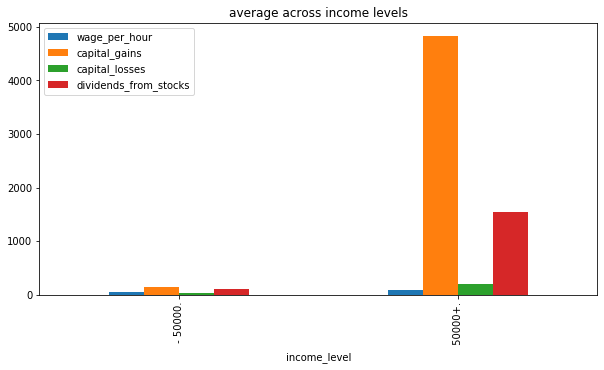

In [229]:
avg = df[['wage_per_hour','capital_gains','capital_losses','dividends_from_stocks','income_level']]\
.groupby('income_level')\
.mean()

avg.plot(kind='bar', title = 'average across income levels', figsize=(10,5))

avg

We can see that people making more than 50k a year, have on average, **higher wage per hour**,**higher return on capital asset** and **dividends from stock options**.

- Next, let's analyse some **categorical variables** :

In [230]:
# Education variable
pd.crosstab(df['income_level'], 
            df['education'],
            margins = True,
           normalize = 'columns').style.format('{:.2%}')

education,Children,Less than 1st grade,1st 2nd 3rd or 4th grade,5th or 6th grade,7th and 8th grade,9th grade,10th grade,11th grade,12th grade no diploma,High school graduate,Associates degree-academic program,Associates degree-occup /vocational,Prof school degree (MD DDS DVM LLB JD),Some college but no degree,Bachelors degree(BA AB BS),Masters degree(MA MS MEng MEd MSW MBA),Doctorate degree(PhD EdD),All
income_level,,,,,,,,,,,,,,,,,,
- 50000.,100.00%,99.88%,99.28%,99.33%,99.10%,99.39%,99.18%,98.98%,98.40%,96.12%,90.56%,92.29%,45.96%,93.58%,80.29%,68.84%,47.98%,93.79%
50000+.,0.00%,0.12%,0.72%,0.67%,0.90%,0.61%,0.82%,1.02%,1.60%,3.88%,9.44%,7.71%,54.04%,6.42%,19.71%,31.16%,52.02%,6.21%


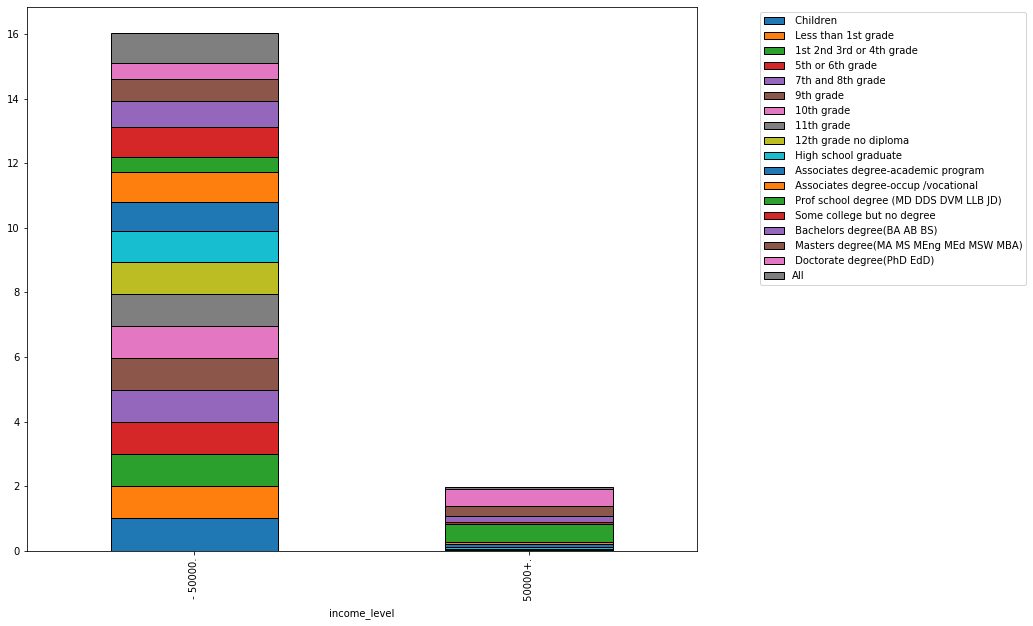

In [231]:
pd.crosstab(df['income_level'], 
            df['education'],
            margins = True,
           normalize = 'columns').plot(kind='bar',stacked=True, edgecolor='black', 
                          figsize=(12,10))

plt.legend(bbox_to_anchor=(1.5, 1.0))

We can see the effect of education on income level where more than 50% of **Prof school degree** and **Doctorate degree** earn more than 50k a year. On the other hand, the majority of people (more than 90%) with **no degree** earn less than 50k a year.

Let's further this analysis and see the effect of **education** and **the number of working weeks** :

In [232]:
pd.crosstab(df['income_level'], 
            df['education'],
            values = df['weeks_worked_in_year'],
            aggfunc = 'mean').round(2)

education,Children,Less than 1st grade,1st 2nd 3rd or 4th grade,5th or 6th grade,7th and 8th grade,9th grade,10th grade,11th grade,12th grade no diploma,High school graduate,Associates degree-academic program,Associates degree-occup /vocational,Prof school degree (MD DDS DVM LLB JD),Some college but no degree,Bachelors degree(BA AB BS),Masters degree(MA MS MEng MEd MSW MBA),Doctorate degree(PhD EdD)
income_level,,,,,,,,,,,,,,,,,
- 50000.,0.0,12.69,15.93,18.56,11.12,13.01,16.23,20.42,21.59,30.88,38.48,37.99,34.55,33.35,37.24,36.94,34.51
50000+.,NaN,0.00,35.00,39.64,39.00,43.47,42.29,46.59,47.71,46.53,49.63,49.46,49.88,47.17,48.66,48.47,48.23


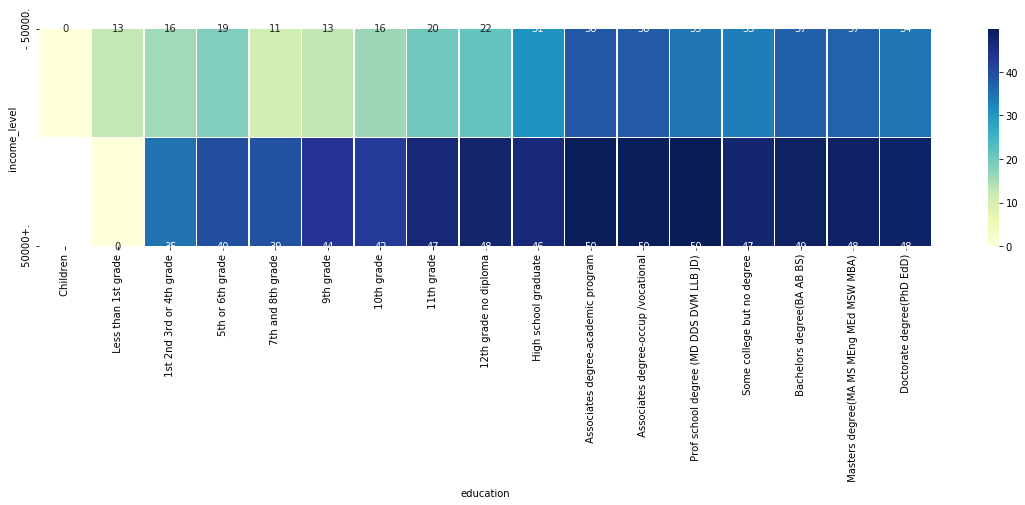

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 4))
sns.heatmap(
    pd.crosstab(df['income_level'], 
            df['education'],
            values = df['weeks_worked_in_year'],
            aggfunc = 'mean').round(1) 
    ,annot = True
    ,linewidths=.5
    ,cmap="YlGnBu"
    
)
plt.show()

We can see that earning more than 50k a year demands high level of education but also lot of hard work !

Let's analyse the effect of **sex** and **marital_stat** on income level : 

In [234]:
pd.crosstab(df['income_level'], 
            [df['sex'],df['marital_stat']],
           margins = True,
           normalize = 'columns').style.format('{:.2%}')

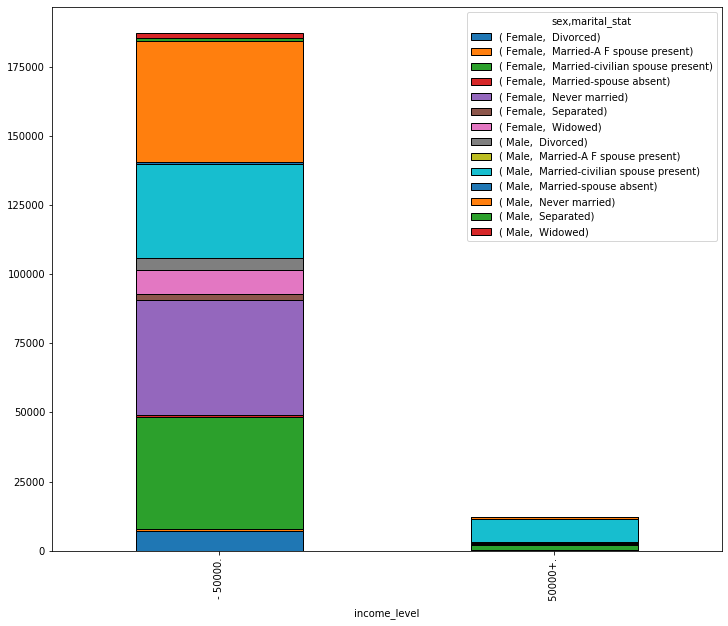

In [235]:
pd.crosstab(df['income_level'], 
            [df['sex'],df['marital_stat']]).plot(kind='bar',stacked=True, edgecolor='black',
                                                 
                          figsize=(12,10))

We can see that the highest proportion of people earning less than 50k a year are mostly **female Married-A F spouse present** or **never married** and **seperated male**. On the other hand, **male Married-civilian spouse present** represent the highest propotion on the +50k income level.

We can further the analysis more as we have got many interesting features with several modalities but for now let's see how machine learning models can help us understanding more our data.

# Data preparation

We set **the feature vector** and **the target variable** :

In [236]:
# setting feature vector and target variable for the train set

X = df.drop(['income_level'], axis = 1)
y = df['income_level']

# setting feature vector and target variable for the test set
test_x = test.drop(['income_level'], axis = 1)
test_y = test['income_level']

In [237]:
# Cheching the result
df.shape, X.shape, y.shape

((199523, 41), (199523, 40), (199523,))

We will keep the provided **test set** hidden and will use it as a realtime dataset when we make our model on production in order to avoid the risk of **data snooping**. 

For that, we will be using a validation set derived from our training set (30%). Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. The simplest function is **train_test_split()**.

Since we have an imbalanced dataset, we can't considered purely random sampling methods. For that, we do stratified sampling based on the **income level**. 

In [238]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.3, 
                                                  random_state=12,
                                                  stratify=y)

In [239]:
# Checking the train and validation set
X_train.shape, X_val.shape

((139666, 40), (59857, 40))

In [240]:
# Checking the income level proportion
y_train.value_counts(normalize = True), y_val.value_counts(normalize = True)

( - 50000.    0.937945
  50000+.     0.062055
 Name: income_level, dtype: float64,
  - 50000.    0.937935
  50000+.     0.062065
 Name: income_level, dtype: float64)

What if we didn't stratify with respect to income level ?

We can compare the income level  proportions in the **overall dataset**, in
the **test set** generated with `stratified sampling`, and in **a test set** generated using `purely random sampling`.

In [241]:
def income_cat_proportions(data):
    return data["income_level"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.3, random_state=12)

train_set, test_set_strat = train_test_split(df, test_size=0.3, random_state=12,stratify=df['income_level'])

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Stratified": income_cat_proportions(test_set_strat),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

As we can see, the test set generated using stratified sampling has
income level proportions almost identical to those in the full dataset, whereas the
test set generated using purely random sampling is skewed.

In [242]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
- 50000.,0.937942,0.937935,0.939305,0.145356,-0.000701
50000+.,0.062058,0.062065,0.060695,-2.196901,0.010601


Now that we defined our training set, It’s time to prepare the data for our machine Learning algorithms.

- Data cleaning :

We have seen previously that we don't have any **missing values**. For some cataegorical features, we assumed that the **?** modality is encoded for NaN values.

- Handling Text and Categorical Attributes :

Strating with the target variable **income_level**, we use **LabelEncoder()** to encode target labels with value between 0 and `n_classes-1 = 1`.

We have seen also that we have some ordinal variable as **education** and **year**, so we use **OrdinalEncoder** to encode the categorical features as an integer array. The results in a single column of integers (0 to n_categories - 1) per feature.

Since the remaining categorical features have several modalities per feature, we use also **OrdinalEncoder** instead of **OneHotEncoder**.
> Working with **OneHotEncoder** leads, in our case, to high memory consumption. We can combine **OneHotEncoder** and **PCA** : The benefit in PCA is that combination of N attributes is better than any individual attribute. And the disadvantage is in harder explanation what exactly that PCA component means. 
Therefore, for this work, we will sacrifice a bit of predictive power to get more understandable model.


In [243]:
# categorical variables encoding
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# For the traget varaible
le = LabelEncoder()
y_train = le.fit_transform(y_train)  #fit on training set
y_val = le.transform(y_val)    
test_y = le.transform(test_y) 


# For categorical features :
Or = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1)
for c in cat : 
        X_train[c] = Or.fit_transform(np.array(X_train[c]).reshape(-1,1).astype(str))  #fit on training set
        X_val[c] = Or.transform(np.array(X_val[c]).reshape(-1,1).astype(str))
        test_x[c] = Or.transform(np.array(test_x[c]).reshape(-1,1).astype(str))

   

In [244]:
# Cheking categorical features encoding
X_train[cat].head(3)

,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,...,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,year
88634,4.0,31.0,14.0,9.0,2.0,2.0,2.0,0.0,4.0,0.0,...,0.0,4.0,40.0,40.0,40.0,4.0,2.0,1.0,2.0,0.0
148296,8.0,37.0,12.0,12.0,2.0,2.0,12.0,2.0,4.0,0.0,...,2.0,4.0,40.0,40.0,40.0,4.0,0.0,1.0,2.0,0.0
163953,3.0,0.0,0.0,10.0,2.0,4.0,14.0,6.0,4.0,0.0,...,0.0,0.0,40.0,40.0,40.0,4.0,0.0,1.0,0.0,0.0


In [245]:
# Cheking target feature encoding
set(y_train)

{0, 1}

- Feature Scaling :

We saw previously that out numerical inputs have different scales like the **weeks_worked_in_year** and **capital_gains**. We will be using **StandardScaler** since standardization is much less affected by outliers.

In [246]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for c in cont:
    X_train[c] = scaler.fit_transform(np.array(X_train[c]).reshape(-1,1)) # fir on the train set
    X_val[c] = scaler.transform(np.array(X_val[c]).reshape(-1,1))
    test_x[c] = scaler.transform(np.array(test_x[c]).reshape(-1,1))



In [247]:
#checking the standardization
X_train[cont].head(3)

,age,wage_per_hour,capital_gains,capital_losses,dividends_from_stocks,num_persons_worked_for_employer,weeks_worked_in_year
88634,0.334269,-0.201648,-0.092139,-0.137611,-0.069026,1.705234,1.177773
148296,0.468715,-0.201648,-0.092139,-0.137611,-0.098703,-0.405865,1.177773
163953,-1.368713,-0.201648,-0.092139,-0.137611,-0.098703,-0.828085,-0.950488


So far, we have handled the **categorical columns** and the **numerical columns** :

In [248]:
# Checking the training set
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        display(X_train.head(3))

X_train.shape, X_val.shape, test_x.shape

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,dividends_from_stocks,tax_filer_stat,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code-change_in_msa,migration_code-change_in_reg,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year
88634,0.334269,4.0,31.0,14.0,9.0,-0.201648,2.0,2.0,2.0,0.0,4.0,0.0,1.0,1.0,3.0,1.0,-0.092139,-0.137611,-0.069026,2.0,3.0,36.0,37.0,7.0,0.0,0.0,0.0,1.0,0.0,1.705234,4.0,40.0,40.0,40.0,4.0,2.0,1.0,2.0,1.177773,0.0
148296,0.468715,8.0,37.0,12.0,12.0,-0.201648,2.0,2.0,12.0,2.0,4.0,0.0,0.0,1.0,3.0,0.0,-0.092139,-0.137611,-0.098703,2.0,3.0,36.0,37.0,7.0,7.0,6.0,7.0,2.0,2.0,-0.405865,4.0,40.0,40.0,40.0,4.0,0.0,1.0,2.0,1.177773,0.0
163953,-1.368713,3.0,0.0,0.0,10.0,-0.201648,2.0,4.0,14.0,6.0,4.0,0.0,1.0,1.0,3.0,0.0,-0.092139,-0.137611,-0.098703,4.0,3.0,36.0,8.0,2.0,0.0,0.0,0.0,1.0,0.0,-0.828085,0.0,40.0,40.0,40.0,4.0,0.0,1.0,0.0,-0.950488,0.0


((139666, 40), (59857, 40), (99762, 40))

# Data modeling

- Selecting a Performance Measure :

**Accuracy** is the simplest way to measure the effectiveness of a
classification task, and it's the percentage of correct predictions over all predictions.
In other words, in a binary classification task, you can calculate this by adding the
number of True Positives (TPs) and True Negatives (TNs) and dividing them by a
tally of all predictions made. As with regression metrics, you can measure accuracy
for both train and test to gauge **overfitting**.

But, we can get an accuracy of 94%, which sounds pretty
good, but it turns out we are always predicting **-50k**! In other words, even if
we get high accuracy, it is meaningless unless we are predicting accurately for the
least represented class, **+50k**.

For this reasing, we will be using **F1-score**.
The **F1-score** is also called the harmonic average of precision and recall because
it's calculated like this: 2TP / 2TP + FP + FN. Since it includes both precision and
recall metrics, which pertain to the proportion of true positives, it's a good metric
choice to use when the dataset is **imbalanced**, and we don't prefer either precision
or recall.

- Base model :

Let's start with **Decision tree ensembles**.

A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.

We illustarte a tree classification using **4 leaf nodes**.

In [249]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

m = DecisionTreeClassifier(max_leaf_nodes=4, random_state=14) # to plot the tree classification
m.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=4, random_state=14)

In [250]:
# to get the class output
m.classes_

array([0, 1])

In [251]:
!pip install pydotplus

In [252]:
!pip install graphviz

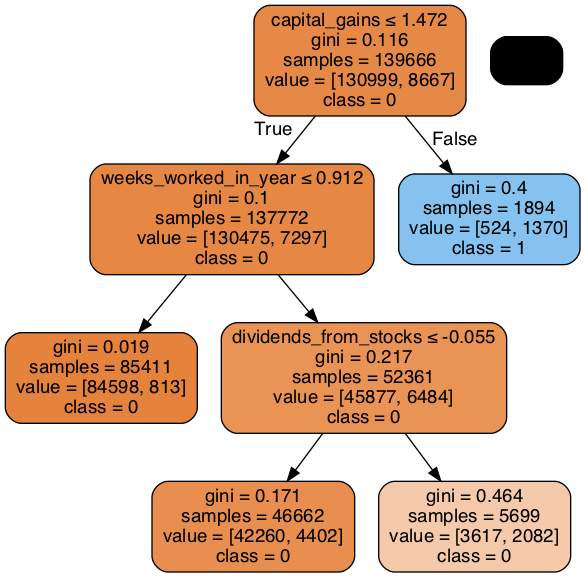

In [253]:
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus
feature_cols = X_train.columns


dot_data = StringIO()
export_graphviz(m, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

The top node represents the **initial model** before any splits have been done, when all the data is in the initial income levels. This is the simplest possible model. It is the result of asking zero questions and will always predict the more represented class which is -50k. We use the **Gini method** to create split points. The strategy  is to select each pair of adjacent values as a possible split-point and the point with smaller gini index chosen as the splitting point. In our case, the **capital gains** at 1.47 was choosen first.

Moving down and to the left, this node shows us that there were 130,999 records for income level of -50k where **capital gains** was less than 1.47. The class predicted is -50k in this case. Moving down and to the right from the initial model takes us to the records where **capital gains** was greater than 1.47. The class predicted is +50k in this case where 1370 records have an income of +50k and **capital gains** >0.4

The bottom row contains our leaf nodes: the nodes with no answers coming out of them, because there are no more questions to be answered.

Returning back to the top node after the first decision point, we can see that a second binary decision split has been made, based on asking whether **weeks_worked_per_year** is less than or equal to 0.9. For the group where this is true, the class predicted is -50k with a gini of 0.019 and there are 85,411 records. For the records where this decision is false,  the class predicted is -50k with a gini of 0.019, and there are 52,361 records. So again, we can see that the decision tree algorithm has successfully split out more  records into two more groups which differ in gini value significantly.

Now, let's run our base model :

In [254]:
m = DecisionTreeClassifier(random_state=14)
m.fit(X_train, y_train)

DecisionTreeClassifier(random_state=14)

We evaluate the model on our validation set using **accuracy**, **recall** and **f1 score** :

In [255]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# on the train set 
accuracy_score(y_train,m.predict(X_train)) , \
recall_score(y_train,m.predict(X_train)), \
f1_score(y_train,m.predict(X_train), average='binary', pos_label=1)


(0.9996348431257428, 0.9943463712934117, 0.997049806212761)

In [256]:
# on the valid set 
accuracy_score(y_val,m.predict(X_val)) , \
recall_score(y_val,m.predict(X_val)), \
f1_score(y_val,m.predict(X_val), average='binary', pos_label=1) 

(0.9307683311893346, 0.4888290713324361, 0.4670781893004115)

It's seems that we are doing badly on the validation set. Let's see houw many leaf nodes we got :

In [257]:
m.get_n_leaves(), len(X_train)

(8005, 139666)

Sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node. Let's change the stopping rule to tell sklearn to ensure every leaf node contains at least 25 records:

In [258]:
m = DecisionTreeClassifier(min_samples_leaf=25,random_state=14)
m.fit(X_train, y_train)

# on the train set 
accuracy_score(y_train,m.predict(X_train)) , \
recall_score(y_train,m.predict(X_train)), \
f1_score(y_train,m.predict(X_train), average='binary', pos_label=1)



(0.9571048071828505, 0.46198223145263645, 0.5720408600614331)

In [259]:
# on the valid set 
accuracy_score(y_val,m.predict(X_val)) , \
recall_score(y_val,m.predict(X_val)), \
f1_score(y_val,m.predict(X_val), average='binary', pos_label=1) 

(0.9504986885410228, 0.42449528936742936, 0.515612228216446)

That looks much better. Let's check the number of leaves again:

In [260]:
m.get_n_leaves(), len(X_train)

(1533, 139666)

We got less leaf nodes than before. So, the more we increase the number of leaf nodes, the more is the possibility of **overfitting**.

Building a **decision tree** is a good way to create a model of our data. It is very flexible, since it can clearly handle nonlinear relationships and interactions between variables. But we can see there is a fundamental compromise between how well it generalizes (which we can achieve by creating small trees) and how accurate it is on the training set (which we can achieve by using large trees).

So how do we get the best of both worlds?

- Ensembling :

An an example of an Ensemble method is **Random Forest** : we can train a group of Decision Tree classifiers,
each on a different random subset of the training set. The process of subseting the data is called **bagging** done with **max_samples** hyperparameter ( we set it at 100.00 samples) and the ramdom selection process this called **bootsraping** done by setting **bootstrap = True**.

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. The remaining  sampled are called **out-of-bag (oob) instances** used as **validation set** in the training process and done by setting **oob_score=True**.

We train a Random Forest classifier **with 50 trees** (each limited to **minimum 5 samples per leaf**).
and instead of searching for the very best feature when splitting a node, we
searches for the best feature among a random subset of 50% of our initial features.

In [261]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 50, max_samples=100_000, max_features=0.5, min_samples_leaf= 5, 
                            bootstrap= True,oob_score = True,random_state=14)

In [262]:
%%time
rf.fit(X_train,y_train)

/Users/rmbp/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


CPU times: user 22.5 s, sys: 339 ms, total: 22.8 s
Wall time: 23.2 s


RandomForestClassifier(max_features=0.5, max_samples=100000, min_samples_leaf=5,
                       n_estimators=50, oob_score=True, random_state=14)

In [263]:
# on the train set 
accuracy_score(y_train,rf.predict(X_train)) , \
recall_score(y_train,rf.predict(X_train)), \
f1_score(y_train,rf.predict(X_train), average='binary', pos_label=1)

(0.9670571219910358, 0.5334025614399446, 0.6677258611973712)

In [264]:
# on the valid set 
accuracy_score(y_val,rf.predict(X_val)) , \
recall_score(y_val,rf.predict(X_val)), \
f1_score(y_val,rf.predict(X_val), average='binary', pos_label=1) 

(0.9546418965200394, 0.41668909825033645, 0.5327826535880227)

Looking at what happens to the **oob error rate** as we add more and more trees, we you can see that the improvement levels off quite a bit after around 40 trees:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Some inputs do not have OOB scores. This probably mean

Text(0, 0.5, 'OOB error rate')

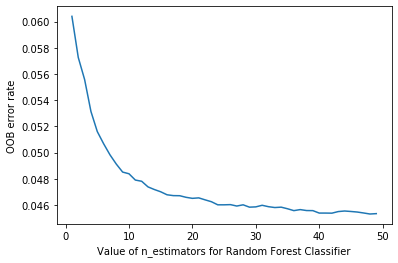

In [377]:
scores =[]
for k in range(1, 50):
    rfc = RandomForestClassifier(n_estimators = k, max_samples=100_000, max_features=0.5, min_samples_leaf= 5, 
                            bootstrap= True,oob_score = True,random_state=14)
    rfc.fit(X_train, y_train)
    #y_pred = rfc.predict(X_val)
    #scores.append(accuracy_score(y_test, y_pred)) oob_score_
    oob_error = 1 - rfc.oob_score_
    scores.append(oob_error)

import matplotlib.pyplot as plt
%matplotlib inline

# plot the relationship between K and testing accuracy
# plt.plot(x_axis, y_axis)
plt.plot(range(1, 50), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
#plt.ylabel('Testing Accuracy')
plt.ylabel('OOB error rate')

Let's try to improve our model : 

We may ask **which columns are the strongest predictors, which can we ignore?**

It's not normally enough just to know that a model can make accurate predictions—we also want to know how it's making predictions. Feature importance gives us insight into this. We can get these directly from sklearn's random forest by looking in the feature_importances_ attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [265]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [266]:
fi = rf_feat_importance(rf, X_train)
fi[:14]

,cols,imp
16,capital_gains,0.161368
18,dividends_from_stocks,0.132382
0,age,0.094106
3,detailed_occupation_recode,0.081452
38,weeks_worked_in_year,0.076202
2,detailed_industry_recode,0.056239
12,sex,0.054394
4,education,0.049652
17,capital_losses,0.047552
29,num_persons_worked_for_employer,0.040222


The feature importances for our model show that the first few most important columns have much higher importance scores than the rest, with (not surprisingly) **capital_gains** and **dividends_from_stocks** being at the top of the list.

A plot of the feature importances shows the relative importances more clearly:

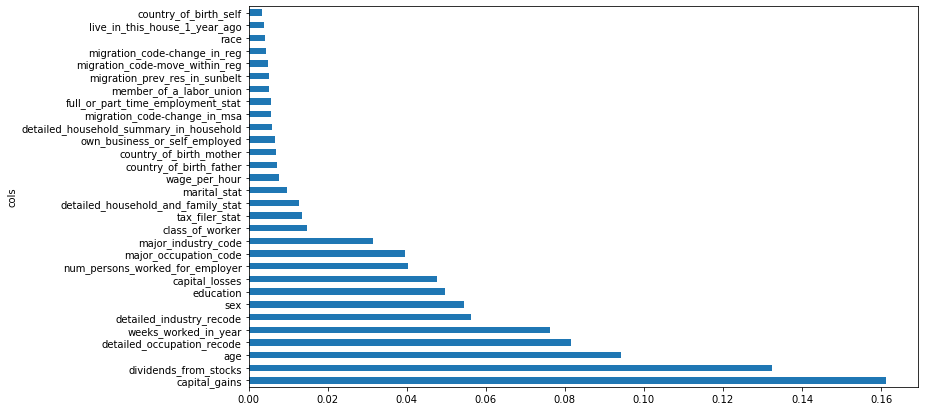

In [267]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

The way these importances are calculated is quite simple yet elegant. The feature importance algorithm loops through each tree, and then recursively explores each branch. At each branch, it looks to see what feature was used for that split, and how much the model improves as a result of that split. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature. This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.

It seems likely that we could use just a subset of the columns by removing the variables of low importance and still get good results. Let's try just keeping those with a feature importance greater than **0.005**:

In [268]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

25

We can retrain our model using just this subset of the columns:

In [269]:
X_train_imp = X_train[to_keep]
X_val_imp = X_val[to_keep]

In [270]:
m = RandomForestClassifier(n_estimators = 50, max_samples=100_000, max_features=0.5, min_samples_leaf= 5, 
                            bootstrap= True,oob_score = True,random_state=14)

m.fit(X_train_imp,y_train)

/Users/rmbp/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


RandomForestClassifier(max_features=0.5, max_samples=100000, min_samples_leaf=5,
                       n_estimators=50, oob_score=True, random_state=14)

In [271]:
# on the train set 
accuracy_score(y_train,m.predict(X_train_imp)) , \
recall_score(y_train,m.predict(X_train_imp)), \
f1_score(y_train,m.predict(X_train_imp), average='binary', pos_label=1)

(0.9670857617458795, 0.5334025614399446, 0.6679188037275157)

In [272]:
# on the valid set 
accuracy_score(y_val,m.predict(X_val_imp)) , \
recall_score(y_val,m.predict(X_val_imp)), \
f1_score(y_val,m.predict(X_val_imp), average='binary', pos_label=1) 

(0.9543077668443123, 0.4142664872139973, 0.5295028384655084)

Our **accuracy is about the same**, but we have **far fewer columns** to study:

In [273]:
len(X_train.columns), len(X_train_imp.columns)

(40, 25)

We've found that generally the first step to improving a model is **simplifying it**—48 columns was too many for us to study them all in depth! Furthermore, in practice often a simpler, more interpretable model is easier to roll out and maintain.

This also makes our feature importance plot easier to interpret. Let's look at it again:

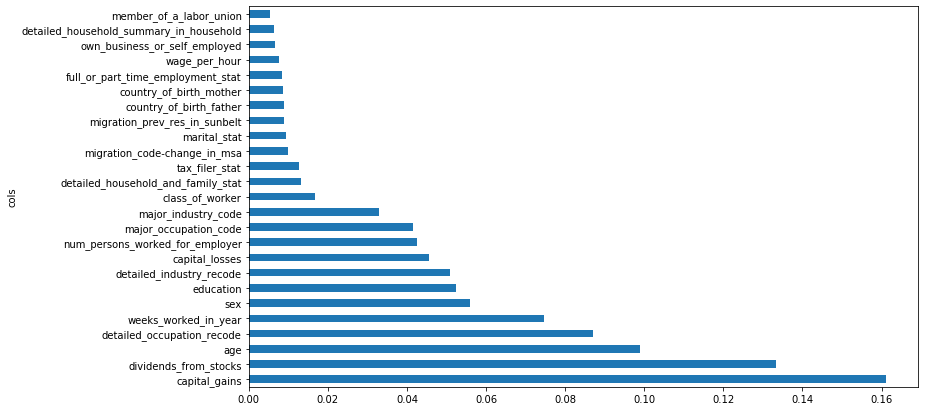

In [274]:
plot_fi(rf_feat_importance(m, X_train_imp));

Let's see if we have redundent feature in our model by determining their similarities :

> Determining Similarity: The most similar pairs are found by calculating the rank correlation, which means that all the values are replaced with their rank (i.e., first, second, third, etc. within the column), and then the correlation is calculated. 

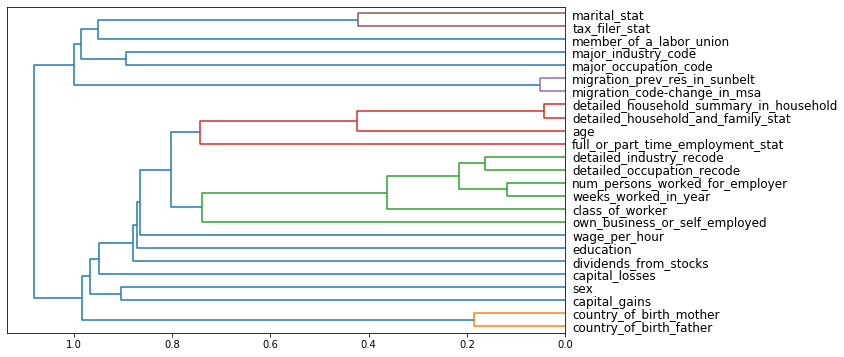

In [275]:
import scipy
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(X_train_imp)

Looking good! This is really not much worse than the model with all the fields. Let's create DataFrames without these columns, and save them:

In [276]:
X_train_final = X_train_imp # train
X_val_final = X_val_imp # valid 

test_x_final = test_x[to_keep] # test set

In [277]:
X_train_final.shape , X_val_final.shape, test_x_final.shape

((139666, 25), (59857, 25), (99762, 25))

# Model Assesment :

We have seen the **DecisionTreeClassifier** as our basemodel, then we tried **RandomForestClassifier** and finaly we tried to optimize so we can have less features for better interpretation. 

Here is the model metrics on our **validation set** :

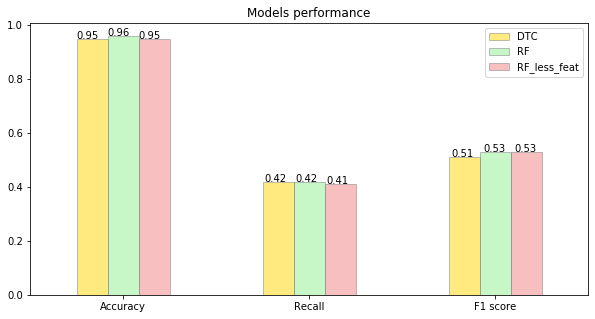

In [278]:
models_metrics = {'DTC': [0.95, 0.42, 0.51], 
                 'RF': [0.96, 0.42, 0.53],
                 'RF_less_feat': [0.95, 0.41, 0.53]
                 
                }
df = pd.DataFrame(data = models_metrics)
df.rename(index={0:'Accuracy',1:'Recall', 2: 'F1 score'}, 
                 inplace=True)
ax = df.plot(kind='bar', figsize = (10,5), 
        color = ['gold', 'lightgreen','lightcoral'],
        rot = 0, title ='Models performance',
        edgecolor = 'grey', alpha = 0.5)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.0005))
plt.show()

Based on **F1 score**, we select the **RandomForestClassifier** with 25 features as our best model.


Let's see the **experiment results*** of this model :

The **precision_recall_curve** and **roc_curve** are useful tools to visualize the **sensitivity-specificty** tradeoff in the classifier. They help inform a data scientist where to set the decision threshold of the model to maximize either sensitivity or specificity. This is called the **operating point** of the model.

In [279]:
from sklearn.metrics import roc_curve, precision_recall_curve, \
auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


In [280]:
# We create an array of the class probabilites called y_scores
y_scores = m.predict_proba(X_val_imp)[:, 1]

# we enerate the precision-recall curve for the classifier:
p, r, thresholds = precision_recall_curve(y_val, y_scores)

# We calculate the  F1 scores
f1_scores = 2*r*p/(r+p)

Let's plot the **decision chart** of our model :

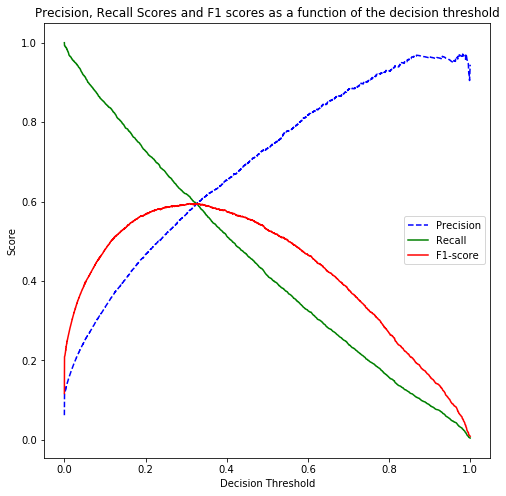

In [281]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision, Recall Scores and F1 scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, f1_scores[:-1], "r-", label="F1-score")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
plot_precision_recall_vs_threshold(p, r, thresholds)    

We can see that the the optimal threshold to achieve the highest F1 score is set at **0.30** with **59% F1-score**.

In [282]:
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.30834595959595956
Best F1-Score:  0.5950888192267503


Let's creat **an animated confusion matrix** where the users get to choose the **threesholds** and we **dislpay the confusion matrix and recall vs precision curve** :

In [283]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [284]:
import ipywidgets as widgets


In [285]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    
    cm = confusion_matrix(y_val, y_pred_adj)
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='RF Confusion matrix')

    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

In [286]:
slider = widgets.IntSlider(
    min=0,
    max=10,
    step=1,
    description='Slider:',
    value=3 # The best threshhold for our model
)
display(slider)



IntSlider(value=3, description='Slider:', max=10)

For this threshold : 0.3, the confusion matrix is as follow :


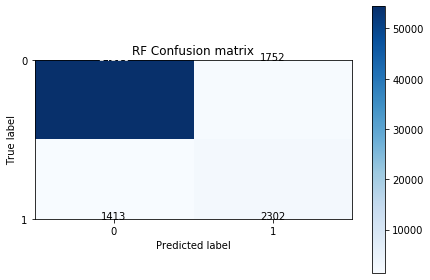

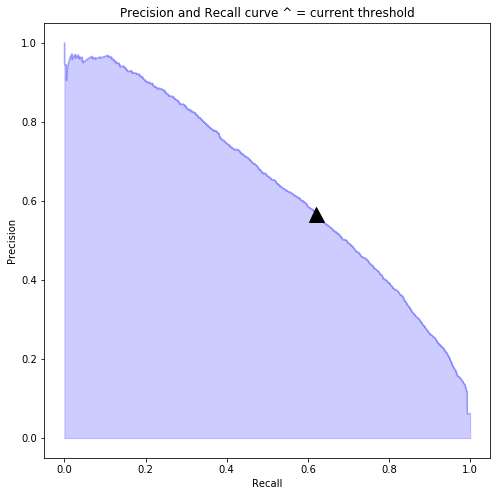

In [287]:
print(f'For this threshold : {slider.value/10}, the confusion matrix is as follow :')
precision_recall_threshold(p, r, thresholds, slider.value/10)

In [288]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

AUC : 0.9433941778952841


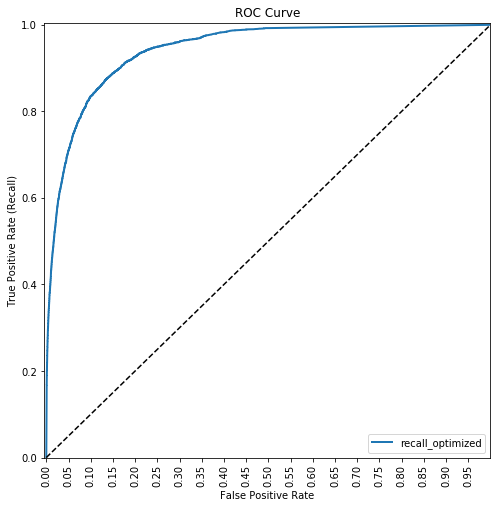

In [289]:
fpr, tpr, auc_thresholds = roc_curve(y_val, y_scores)
print(f'AUC : {auc(fpr, tpr)}') # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

Now, let's test this model on our **test set** : 

In [290]:
accuracy_score(test_y,m.predict(test_x_final)) , \
recall_score(test_y,m.predict(test_x_final)) , \
f1_score(test_y,m.predict(test_x_final), average='binary', pos_label=1)

(0.9546420480744171, 0.4183640478499838, 0.5335532419338213)

# Results : Partial dependency and SHAP values

Let's look at **partial dependence plots**. 

**Partial dependence** plots try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

For instance, how does **capital_gains** and **dividends_from_stocks** impact probability of belonging to the +50k income levl, all other things being equal?

/Users/rmbp/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


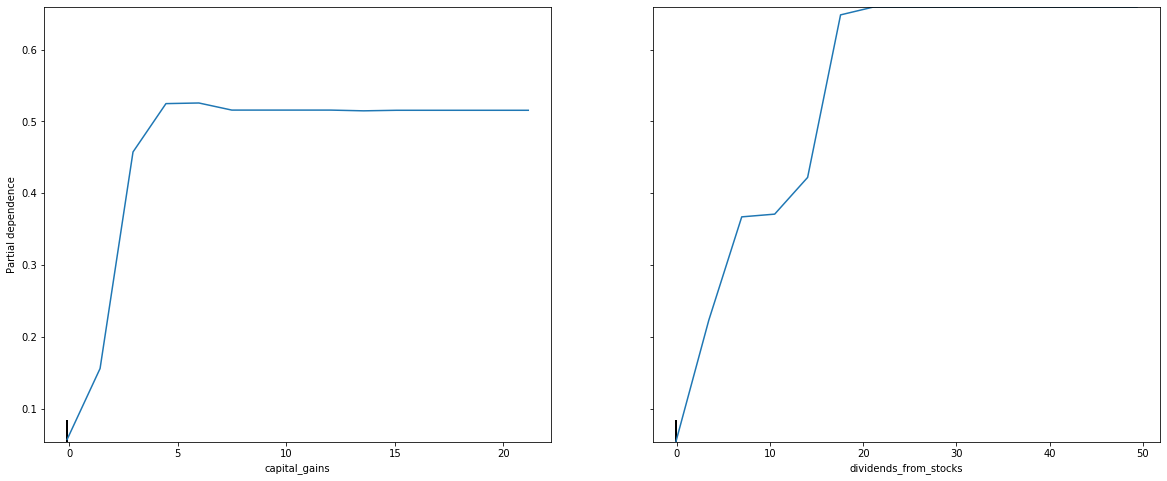

In [291]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(20, 8))
plot_partial_dependence(m, X_val_final, ['capital_gains','dividends_from_stocks'], percentiles=(0,1),
                        grid_resolution=15, ax=ax);

Looking first at the **dividends_from_stocks** plot, we can see a nearly linear relationship between capital dividends_from_stocks and the probabillity of income level.
Same for **capital_gains** at 5 standad deviation from the mean after reaching a steady state above that.

In [292]:
!pip install shap

In [293]:
import shap

In [370]:
row_to_show = 20
data_for_prediction = test_x_final.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired


In [371]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(m)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [372]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

- The base_value here is 0.062 while our predicted value is 0.0.
- sex = 1 has the biggest impact on increasing the prediction, while
- Weeks_worked_im_year (below the average) and Age (below the average) feature has the biggest effect in decreasing the prediction.

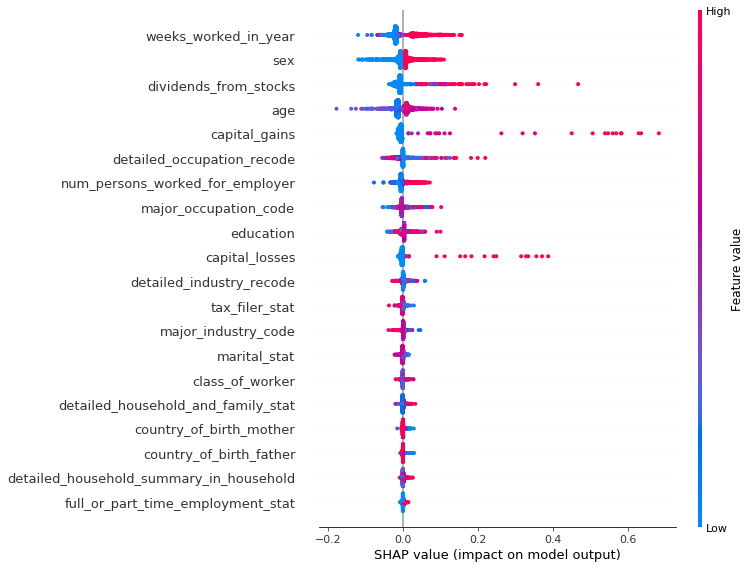

In [373]:
explainer = shap.TreeExplainer(m)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(test_x_final.iloc[:1000,])

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1],test_x_final.iloc[:1000,])

For every dot:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For the **age** variable, the point in the upper left was depicts a person whose age level is less thereby reducing the prediction of income level +50k class by 0.2.

# Conclusion :

In this work, we presented some techniques for dealing with a machine learning project :

- We used Decision Tree ensembles : Random Forest are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if we have enough trees.

- we used the model for feature selection and partial dependence analysis and Shap values, to get a better understanding of our data.

For futur improvements :
- We can try Gradient Boosting machines as in theory are just as fast to train as random forests, but in practice we will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

- We can try OneHotEncoder with PCA to deal with the multiple modalities on our categorical variables.

- We can creat new features to challenge the model performance.